Import des packages

In [0]:
import requests
import pandas as pd
import time
import matplotlib.pyplot as plt
from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType
from sklearn.cluster import KMeans
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns

In [0]:
# Fonction pour récupérer les données d'un Pokémon par son ID
def get_pokemon_data(pokemon_id):
    url = f"https://pokeapi.co/api/v2/pokemon/{pokemon_id}/"
    response = requests.get(url)
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Erreur: Impossible de récupérer les données pour l'ID {pokemon_id}")
        return None

# Récupérer les données pour les Pokémon
pokemon_list = []
for pokemon_id in range(1, 1021):
    data = get_pokemon_data(pokemon_id)
    if data:
        name = data['name']
        height = data['height']
        weight = data['weight']
        stats = {stat['stat']['name']: stat['base_stat'] for stat in data['stats']}
        types = [t['type']['name'] for t in data['types']]
        pokemon_list.append({
            'id': pokemon_id,
            'name': name,
            'height': height,
            'weight': weight,
            **stats,
            'types': types
        })
    
    # Ajouter une pause pour éviter de surcharger l'API
    if pokemon_id % 100 == 0:  # Pause après chaque 100 Pokémon
        time.sleep(1)

# Créer un DataFrame avec les données récupérées
df_pokemon = pd.DataFrame(pokemon_list)
df_pokemon.head()

,id,name,height,weight,hp,attack,defense,special-attack,special-defense,speed,types
0,1,bulbasaur,7,69,45,49,49,65,65,45,"[grass, poison]"
1,2,ivysaur,10,130,60,62,63,80,80,60,"[grass, poison]"
2,3,venusaur,20,1000,80,82,83,100,100,80,"[grass, poison]"
3,4,charmander,6,85,39,52,43,60,50,65,[fire]
4,5,charmeleon,11,190,58,64,58,80,65,80,[fire]


In [0]:
df_pokemon.count()

id                 1020
name               1020
height             1020
weight             1020
hp                 1020
attack             1020
defense            1020
special-attack     1020
special-defense    1020
speed              1020
types              1020
dtype: int64

In [0]:
# Convertir le DataFrame Pandas en Spark DataFrame
df_spark = spark.createDataFrame(df_pokemon)

# Enregistrer les données brutes dans Delta Lake
df_spark.write.format("delta").mode("overwrite").save("/mnt/datalake/pokemon_raw")

In [0]:
# Lire les données brutes depuis Delta Lake
df_raw = spark.read.format("delta").load("/mnt/datalake/pokemon_raw")
display(df_raw.show(5))

+---+----------+------+------+---+------+-------+--------------+---------------+-----+---------------+
| id|      name|height|weight| hp|attack|defense|special-attack|special-defense|speed|          types|
+---+----------+------+------+---+------+-------+--------------+---------------+-----+---------------+
|  1| bulbasaur|     7|    69| 45|    49|     49|            65|             65|   45|[grass, poison]|
|  2|   ivysaur|    10|   130| 60|    62|     63|            80|             80|   60|[grass, poison]|
|  3|  venusaur|    20|  1000| 80|    82|     83|           100|            100|   80|[grass, poison]|
|  4|charmander|     6|    85| 39|    52|     43|            60|             50|   65|         [fire]|
|  5|charmeleon|    11|   190| 58|    64|     58|            80|             65|   80|         [fire]|
+---+----------+------+------+---+------+-------+--------------+---------------+-----+---------------+
only showing top 5 rows



In [0]:
# Convertir Spark DataFrame en Pandas pour certaines opérations
df_cleaned = df_raw.toPandas()

# Vérifier les valeurs manquantes
print(df_cleaned.isnull().sum())

id                 0
name               0
height             0
weight             0
hp                 0
attack             0
defense            0
special-attack     0
special-defense    0
speed              0
types              0
dtype: int64


In [0]:
# Ajouter une colonne de puissance totale en sommant les statistiques
stat_columns = ['hp', 'attack', 'defense', 'special-attack', 'special-defense', 'speed']
df_cleaned['total_power'] = df_cleaned[stat_columns].sum(axis=1)

In [0]:
# Ajouter une colonne d'attaque en sommant les statistiques d'attaque et attaque spéciale
stat_columns = ['attack', 'special-attack']
df_cleaned['total_attack'] = df_cleaned[stat_columns].sum(axis=1)

In [0]:
# Ajouter une colonne de défense en sommant les statistiques de défense et de défense spéciale
stat_columns = ['defense', 'special-defense']
df_cleaned['total_defense'] = df_cleaned[stat_columns].sum(axis=1)

In [0]:
# Ajouter une colonne de physique en sommant les statistiques d'attaque et de défense
stat_columns = ['attack', 'defense']
df_cleaned['total_physic'] = df_cleaned[stat_columns].sum(axis=1)

In [0]:
# Ajouter une colonne de physique en sommant les statistiques d'attaque spéciale et de défense spéciale
stat_columns = ['special-attack', 'special-defense']
df_cleaned['total_special'] = df_cleaned[stat_columns].sum(axis=1)

In [0]:
df_cleaned.head()

,id,name,height,weight,hp,attack,defense,special-attack,special-defense,speed,types,total_power,total_attack,total_defense,total_physic,total_special
0,1,bulbasaur,7,69,45,49,49,65,65,45,"[grass, poison]",318,114,114,98,130
1,2,ivysaur,10,130,60,62,63,80,80,60,"[grass, poison]",405,142,143,125,160
2,3,venusaur,20,1000,80,82,83,100,100,80,"[grass, poison]",525,182,183,165,200
3,4,charmander,6,85,39,52,43,60,50,65,[fire],309,112,93,95,110
4,5,charmeleon,11,190,58,64,58,80,65,80,[fire],405,144,123,122,145


In [0]:
# Convertir de nouveau en Spark DataFrame
df_spark_cleaned = spark.createDataFrame(df_cleaned)

# Enregistrer les données nettoyées dans Delta Lake
df_spark_cleaned.write.format("delta").mode("overwrite").save("/mnt/datalake/pokemon_clean")

In [0]:
# Lire les données nettoyées depuis Delta Lake
df_clean = spark.read.format("delta").load("/mnt/datalake/pokemon_clean")

In [0]:
# Créer une vue
df_clean.createOrReplaceTempView("pokemon_clean")

# Requête SQL pour classer les Pokémon par la puissance totale
top_pokemon = spark.sql("""
    SELECT id
            , name
            , hp
            , attack
            , defense
            , `special-attack`
            , `special-defense`
            , speed
            , total_power
            , types
            , total_attack
            , total_defense
            , total_physic
            , total_special
    FROM pokemon_clean
    ORDER BY total_power DESC
    LIMIT 10
""")

display(top_pokemon)

# Requête SQL pour classer les Pokémon par l'attaque totale
top_pokemon_attack = spark.sql("""
    SELECT id
            , name
            , hp
            , attack
            , defense
            , `special-attack`
            , `special-defense`
            , speed
            , total_power
            , types
            , total_attack
            , total_defense
            , total_physic
            , total_special
    FROM pokemon_clean
    ORDER BY total_attack DESC
    LIMIT 10
""")

display(top_pokemon_attack)

# Requête SQL pour classer les Pokémon par la défense totale
top_pokemon_defense = spark.sql("""
    SELECT id
            , name
            , hp
            , attack
            , defense
            , `special-attack`
            , `special-defense`
            , speed
            , total_power
            , types
            , total_attack
            , total_defense
            , total_physic
            , total_special
    FROM pokemon_clean
    ORDER BY total_defense DESC
    LIMIT 10
""")

display(top_pokemon_defense)

# Requête SQL pour classer les Pokémon par le physique total
top_pokemon_physic = spark.sql("""
    SELECT id
            , name
            , hp
            , attack
            , defense
            , `special-attack`
            , `special-defense`
            , speed
            , total_power
            , types
            , total_attack
            , total_defense
            , total_physic
            , total_special
    FROM pokemon_clean
    ORDER BY total_physic DESC
    LIMIT 10
""")

display(top_pokemon_physic)

# Requête SQL pour classer les Pokémon par le spécial total
top_pokemon_special = spark.sql("""
    SELECT id
            , name
            , hp
            , attack
            , defense
            , `special-attack`
            , `special-defense`
            , speed
            , total_power
            , types
            , total_attack
            , total_defense
            , total_physic
            , total_special
    FROM pokemon_clean
    ORDER BY total_special DESC
    LIMIT 10
""")

display(top_pokemon_special)

# Requête SQL pour classer les Pokémon par les points de vie
top_pokemon_hp = spark.sql("""
    SELECT id
            , name
            , hp
            , attack
            , defense
            , `special-attack`
            , `special-defense`
            , speed
            , total_power
            , types
            , total_attack
            , total_defense
            , total_physic
            , total_special
    FROM pokemon_clean
    ORDER BY hp DESC
    LIMIT 10
""")

display(top_pokemon_hp)

# Requête SQL pour classer les Pokémon par la vitesse
top_pokemon_speed = spark.sql("""
    SELECT id
            , name
            , hp
            , attack
            , defense
            , `special-attack`
            , `special-defense`
            , speed
            , total_power
            , types
            , total_attack
            , total_defense
            , total_physic
            , total_special
    FROM pokemon_clean
    ORDER BY speed DESC
    LIMIT 10
""")

display(top_pokemon_speed)

id,name,hp,attack,defense,special-attack,special-defense,speed,total_power,types,total_attack,total_defense,total_physic,total_special
493,arceus,120,120,120,120,120,120,720,List(normal),240,240,240,240
890,eternatus,140,85,95,145,95,130,690,"List(poison, dragon)",230,190,180,240
250,ho-oh,106,130,90,110,154,90,680,"List(fire, flying)",240,244,220,264
150,mewtwo,106,110,90,154,90,130,680,List(psychic),264,180,200,244
384,rayquaza,105,150,90,150,90,95,680,"List(dragon, flying)",300,180,240,240
249,lugia,106,90,130,90,154,110,680,"List(psychic, flying)",180,284,220,244
487,giratina-altered,150,100,120,100,120,90,680,"List(ghost, dragon)",200,240,220,220
643,reshiram,100,120,100,150,120,90,680,"List(dragon, fire)",270,220,220,270
483,dialga,100,120,120,150,100,90,680,"List(steel, dragon)",270,220,240,250
484,palkia,90,120,100,150,120,100,680,"List(water, dragon)",270,220,220,270


id,name,hp,attack,defense,special-attack,special-defense,speed,total_power,types,total_attack,total_defense,total_physic,total_special
384,rayquaza,105,150,90,150,90,95,680,"List(dragon, flying)",300,180,240,240
386,deoxys-normal,50,150,50,150,50,150,600,List(psychic),300,100,200,200
806,blacephalon,53,127,53,151,79,107,570,"List(fire, ghost)",278,132,180,230
795,pheromosa,71,137,37,137,37,151,570,"List(bug, fighting)",274,74,174,174
644,zekrom,100,150,120,120,100,90,680,"List(dragon, electric)",270,220,270,220
484,palkia,90,120,100,150,120,100,680,"List(water, dragon)",270,220,220,270
643,reshiram,100,120,100,150,120,90,680,"List(dragon, fire)",270,220,220,270
483,dialga,100,120,120,150,100,90,680,"List(steel, dragon)",270,220,240,250
150,mewtwo,106,110,90,154,90,130,680,List(psychic),264,180,200,244
716,xerneas,126,131,95,131,98,99,680,List(fairy),262,193,226,229


id,name,hp,attack,defense,special-attack,special-defense,speed,total_power,types,total_attack,total_defense,total_physic,total_special
213,shuckle,20,10,230,10,230,5,505,"List(bug, rock)",20,460,240,240
805,stakataka,61,131,211,53,101,13,570,"List(rock, steel)",184,312,342,154
411,bastiodon,60,52,168,47,138,30,495,"List(rock, steel)",99,306,220,185
377,regirock,80,100,200,50,100,50,580,List(rock),150,300,300,150
719,diancie,50,100,150,100,150,50,600,"List(rock, fairy)",200,300,250,250
703,carbink,50,50,150,50,150,50,500,"List(rock, fairy)",100,300,200,200
379,registeel,80,75,150,75,150,50,580,List(steel),150,300,225,225
378,regice,80,50,100,100,200,50,580,List(ice),150,300,150,300
476,probopass,60,55,145,75,150,40,525,"List(rock, steel)",130,295,200,225
748,toxapex,50,63,152,53,142,35,495,"List(poison, water)",116,294,215,195


id,name,hp,attack,defense,special-attack,special-defense,speed,total_power,types,total_attack,total_defense,total_physic,total_special
805,stakataka,61,131,211,53,101,13,570,"List(rock, steel)",184,312,342,154
798,kartana,59,181,131,59,31,109,570,"List(grass, steel)",240,162,312,90
713,avalugg,95,117,184,44,46,28,514,List(ice),161,230,301,90
377,regirock,80,100,200,50,100,50,580,List(rock),150,300,300,150
306,aggron,70,110,180,60,60,50,530,"List(steel, rock)",170,240,290,120
383,groudon,100,150,140,100,90,90,670,List(ground),250,230,290,190
809,melmetal,135,143,143,80,65,34,600,List(steel),223,208,286,145
208,steelix,75,85,200,55,65,30,510,"List(steel, ground)",140,265,285,120
794,buzzwole,107,139,139,53,53,79,570,"List(bug, fighting)",192,192,278,106
91,cloyster,50,95,180,85,45,70,525,"List(water, ice)",180,225,275,130


id,name,hp,attack,defense,special-attack,special-defense,speed,total_power,types,total_attack,total_defense,total_physic,total_special
378,regice,80,50,100,100,200,50,580,List(ice),150,300,150,300
382,kyogre,100,100,90,150,140,90,670,List(water),250,230,190,290
720,hoopa,80,110,60,150,130,70,600,"List(psychic, ghost)",260,190,170,280
864,cursola,60,95,50,145,130,30,510,List(ghost),240,180,145,275
987,flutter-mane,55,55,55,135,135,135,570,"List(ghost, fairy)",190,190,110,270
643,reshiram,100,120,100,150,120,90,680,"List(dragon, fire)",270,220,220,270
484,palkia,90,120,100,150,120,100,680,"List(water, dragon)",270,220,220,270
671,florges,78,65,68,112,154,75,552,List(fairy),177,222,133,266
250,ho-oh,106,130,90,110,154,90,680,"List(fire, flying)",240,244,220,264
706,goodra,90,100,70,110,150,80,600,List(dragon),210,220,170,260


id,name,hp,attack,defense,special-attack,special-defense,speed,total_power,types,total_attack,total_defense,total_physic,total_special
242,blissey,255,10,10,75,135,55,540,List(normal),85,145,20,210
113,chansey,250,5,5,35,105,50,450,List(normal),40,110,10,140
799,guzzlord,223,101,53,97,53,43,570,"List(dark, dragon)",198,106,154,150
895,regidrago,200,100,50,100,50,80,580,List(dragon),200,100,150,150
202,wobbuffet,190,33,58,33,58,33,405,List(psychic),66,116,91,91
321,wailord,170,90,45,90,45,60,500,List(water),180,90,135,135
975,cetitan,170,113,65,45,55,73,521,List(ice),158,120,178,100
594,alomomola,165,75,80,40,45,65,470,List(water),115,125,155,85
143,snorlax,160,110,65,65,110,30,540,List(normal),175,175,175,175
1003,ting-lu,155,110,125,55,80,45,570,"List(dark, ground)",165,205,235,135


id,name,hp,attack,defense,special-attack,special-defense,speed,total_power,types,total_attack,total_defense,total_physic,total_special
894,regieleki,80,100,50,100,50,200,580,List(electric),200,100,150,150
291,ninjask,61,90,45,50,50,160,456,"List(bug, flying)",140,95,135,100
795,pheromosa,71,137,37,137,37,151,570,"List(bug, fighting)",274,74,174,174
386,deoxys-normal,50,150,50,150,50,150,600,List(psychic),300,100,200,200
101,electrode,60,50,70,80,80,150,490,List(electric),130,150,120,160
617,accelgor,80,70,40,100,60,145,495,List(bug),170,100,110,160
807,zeraora,88,112,75,102,80,143,600,List(electric),214,155,187,182
887,dragapult,88,120,75,100,75,142,600,"List(dragon, ghost)",220,150,195,175
888,zacian,92,120,115,80,115,138,660,List(fairy),200,230,235,195
889,zamazenta,92,120,115,80,115,138,660,List(fighting),200,230,235,195


In [0]:
# Trier les Pokémon par puissance totale décroissante et sélectionner les 10 premiers
top_pokemon_total_power_df = df_clean.orderBy(df_clean.total_power.desc()).limit(10)
display(top_pokemon_total_power_df)

id,name,height,weight,hp,attack,defense,special-attack,special-defense,speed,types,total_power,total_attack,total_defense,total_physic,total_special
493,arceus,32,3200,120,120,120,120,120,120,List(normal),720,240,240,240,240
890,eternatus,200,9500,140,85,95,145,95,130,"List(poison, dragon)",690,230,190,180,240
250,ho-oh,38,1990,106,130,90,110,154,90,"List(fire, flying)",680,240,244,220,264
150,mewtwo,20,1220,106,110,90,154,90,130,List(psychic),680,264,180,200,244
384,rayquaza,70,2065,105,150,90,150,90,95,"List(dragon, flying)",680,300,180,240,240
249,lugia,52,2160,106,90,130,90,154,110,"List(psychic, flying)",680,180,284,220,244
487,giratina-altered,45,7500,150,100,120,100,120,90,"List(ghost, dragon)",680,200,240,220,220
643,reshiram,32,3300,100,120,100,150,120,90,"List(dragon, fire)",680,270,220,220,270
483,dialga,54,6830,100,120,120,150,100,90,"List(steel, dragon)",680,270,220,240,250
484,palkia,42,3360,90,120,100,150,120,100,"List(water, dragon)",680,270,220,220,270


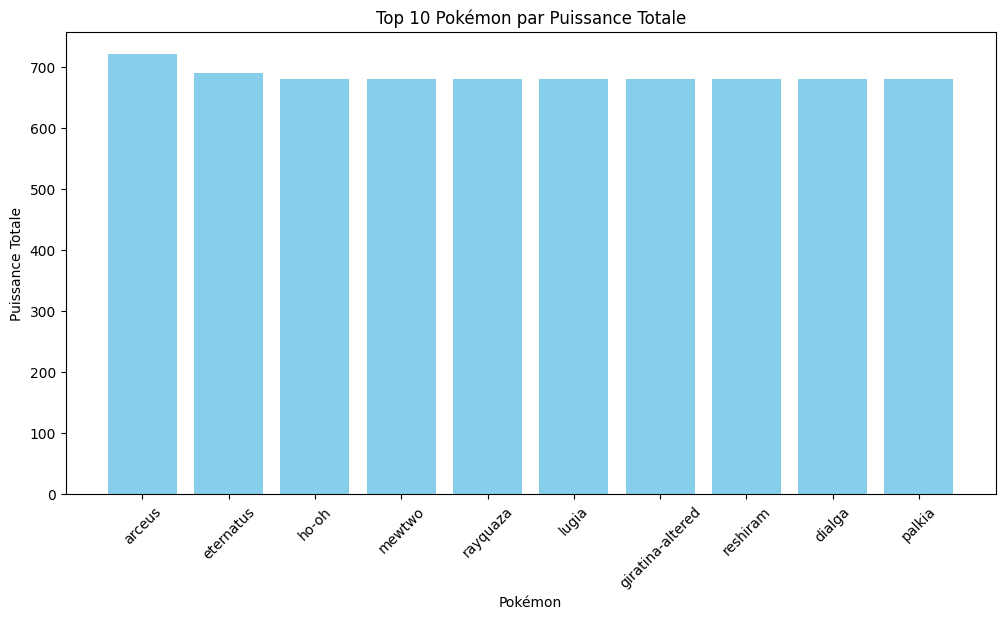

In [0]:
# Convertir Spark DataFrame en Pandas
top_pokemon_total_power_pd = top_pokemon_total_power_df.toPandas()

# Bar chart des top 10 Pokémon par puissance totale
plt.figure(figsize=(12, 6))
plt.bar(top_pokemon_total_power_pd['name'], top_pokemon_total_power_pd['total_power'], color='skyblue')
plt.title('Top 10 Pokémon par puissance totale')
plt.xlabel('Pokémon')
plt.ylabel('Puissance totale')
plt.xticks(rotation=45)
plt.show()

In [0]:
# Trier les Pokémon par attaque totale décroissante et sélectionner les 10 premiers
top_pokemon_total_attack_df = df_clean.orderBy(df_clean.total_attack.desc()).limit(10)
display(top_pokemon_total_attack_df)

id,name,height,weight,hp,attack,defense,special-attack,special-defense,speed,types,total_power,total_attack,total_defense,total_physic,total_special
384,rayquaza,70,2065,105,150,90,150,90,95,"List(dragon, flying)",680,300,180,240,240
386,deoxys-normal,17,608,50,150,50,150,50,150,List(psychic),600,300,100,200,200
806,blacephalon,18,130,53,127,53,151,79,107,"List(fire, ghost)",570,278,132,180,230
795,pheromosa,18,250,71,137,37,137,37,151,"List(bug, fighting)",570,274,74,174,174
644,zekrom,29,3450,100,150,120,120,100,90,"List(dragon, electric)",680,270,220,270,220
484,palkia,42,3360,90,120,100,150,120,100,"List(water, dragon)",680,270,220,220,270
643,reshiram,32,3300,100,120,100,150,120,90,"List(dragon, fire)",680,270,220,220,270
483,dialga,54,6830,100,120,120,150,100,90,"List(steel, dragon)",680,270,220,240,250
150,mewtwo,20,1220,106,110,90,154,90,130,List(psychic),680,264,180,200,244
716,xerneas,30,2150,126,131,95,131,98,99,List(fairy),680,262,193,226,229


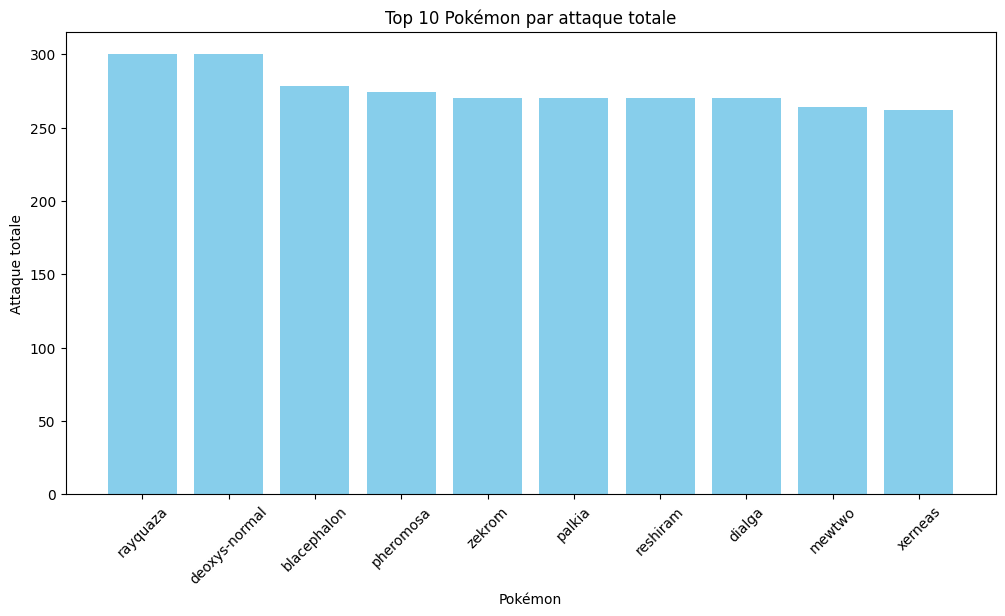

In [0]:
# Convertir Spark DataFrame en Pandas
top_pokemon_total_attack_pd = top_pokemon_total_attack_df.toPandas()

# Bar chart des top 10 Pokémon par attaque totale
plt.figure(figsize=(12, 6))
plt.bar(top_pokemon_total_attack_pd['name'], top_pokemon_total_attack_pd['total_attack'], color='skyblue')
plt.title('Top 10 Pokémon par attaque totale')
plt.xlabel('Pokémon')
plt.ylabel('Attaque totale')
plt.xticks(rotation=45)
plt.show()

In [0]:
# Trier les Pokémon par défense totale décroissante et sélectionner les 10 premiers
top_pokemon_total_defense_df = df_clean.orderBy(df_clean.total_defense.desc()).limit(10)
display(top_pokemon_total_defense_df)

id,name,height,weight,hp,attack,defense,special-attack,special-defense,speed,types,total_power,total_attack,total_defense,total_physic,total_special
213,shuckle,6,205,20,10,230,10,230,5,"List(bug, rock)",505,20,460,240,240
805,stakataka,55,8200,61,131,211,53,101,13,"List(rock, steel)",570,184,312,342,154
411,bastiodon,13,1495,60,52,168,47,138,30,"List(rock, steel)",495,99,306,220,185
377,regirock,17,2300,80,100,200,50,100,50,List(rock),580,150,300,300,150
719,diancie,7,88,50,100,150,100,150,50,"List(rock, fairy)",600,200,300,250,250
703,carbink,3,57,50,50,150,50,150,50,"List(rock, fairy)",500,100,300,200,200
379,registeel,19,2050,80,75,150,75,150,50,List(steel),580,150,300,225,225
378,regice,18,1750,80,50,100,100,200,50,List(ice),580,150,300,150,300
476,probopass,14,3400,60,55,145,75,150,40,"List(rock, steel)",525,130,295,200,225
748,toxapex,7,145,50,63,152,53,142,35,"List(poison, water)",495,116,294,215,195


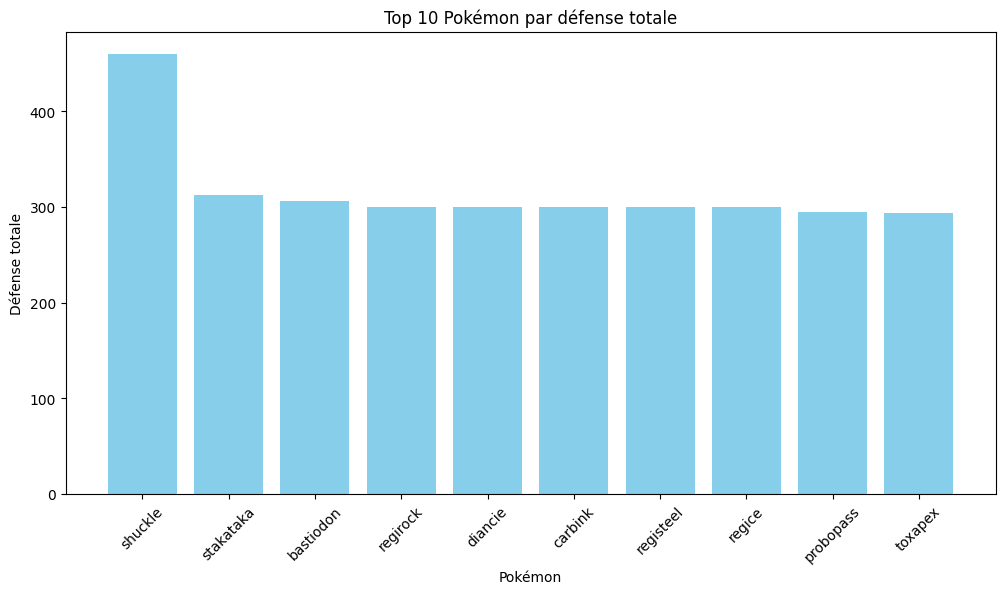

In [0]:
# Convertir Spark DataFrame en Pandas
top_pokemon_total_defense_pd = top_pokemon_total_defense_df.toPandas()

# Bar chart des top 10 Pokémon par défense totale
plt.figure(figsize=(12, 6))
plt.bar(top_pokemon_total_defense_pd['name'], top_pokemon_total_defense_pd['total_defense'], color='skyblue')
plt.title('Top 10 Pokémon par défense totale')
plt.xlabel('Pokémon')
plt.ylabel('Défense totale')
plt.xticks(rotation=45)
plt.show()

In [0]:
# Trier les Pokémon par le physique total décroissant et sélectionner les 10 premiers
top_pokemon_total_physic_df = df_clean.orderBy(df_clean.total_physic.desc()).limit(10)
display(top_pokemon_total_physic_df)

id,name,height,weight,hp,attack,defense,special-attack,special-defense,speed,types,total_power,total_attack,total_defense,total_physic,total_special
805,stakataka,55,8200,61,131,211,53,101,13,"List(rock, steel)",570,184,312,342,154
798,kartana,3,1,59,181,131,59,31,109,"List(grass, steel)",570,240,162,312,90
713,avalugg,20,5050,95,117,184,44,46,28,List(ice),514,161,230,301,90
377,regirock,17,2300,80,100,200,50,100,50,List(rock),580,150,300,300,150
306,aggron,21,3600,70,110,180,60,60,50,"List(steel, rock)",530,170,240,290,120
383,groudon,35,9500,100,150,140,100,90,90,List(ground),670,250,230,290,190
809,melmetal,25,8000,135,143,143,80,65,34,List(steel),600,223,208,286,145
208,steelix,92,4000,75,85,200,55,65,30,"List(steel, ground)",510,140,265,285,120
794,buzzwole,24,3336,107,139,139,53,53,79,"List(bug, fighting)",570,192,192,278,106
91,cloyster,15,1325,50,95,180,85,45,70,"List(water, ice)",525,180,225,275,130


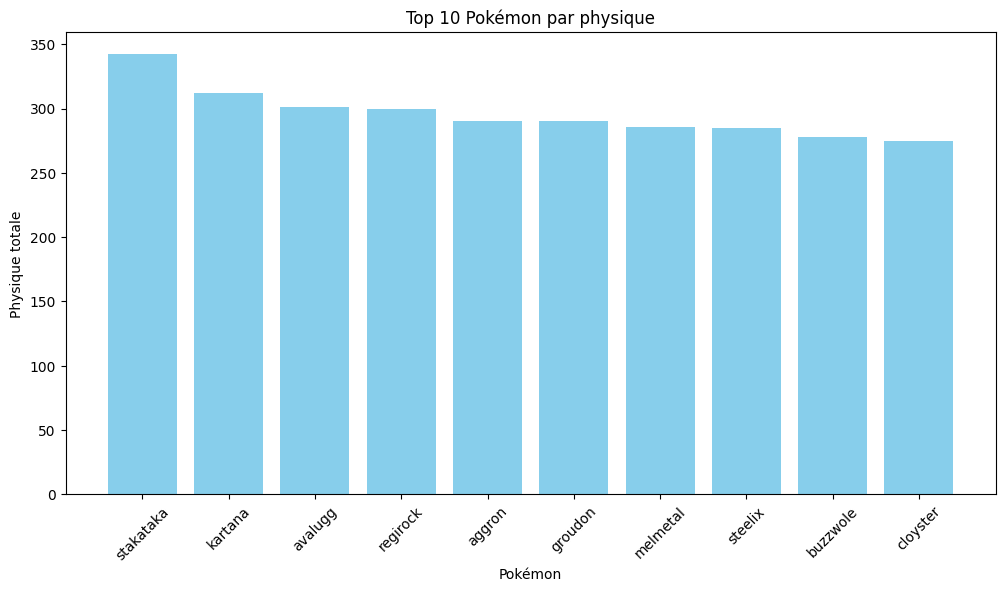

In [0]:
# Convertir Spark DataFrame en Pandas
top_pokemon_total_physic_pd = top_pokemon_total_physic_df.toPandas()

# Bar chart des top 10 Pokémon par pysique
plt.figure(figsize=(12, 6))
plt.bar(top_pokemon_total_physic_pd['name'], top_pokemon_total_physic_pd['total_physic'], color='skyblue')
plt.title('Top 10 Pokémon par physique')
plt.xlabel('Pokémon')
plt.ylabel('Physique totale')
plt.xticks(rotation=45)
plt.show()

In [0]:
# Trier les Pokémon par le spécial total décroissant et sélectionner les 10 premiers
top_pokemon_total_special_df = df_clean.orderBy(df_clean.total_special.desc()).limit(10)
display(top_pokemon_total_special_df)

id,name,height,weight,hp,attack,defense,special-attack,special-defense,speed,types,total_power,total_attack,total_defense,total_physic,total_special
378,regice,18,1750,80,50,100,100,200,50,List(ice),580,150,300,150,300
382,kyogre,45,3520,100,100,90,150,140,90,List(water),670,250,230,190,290
720,hoopa,5,90,80,110,60,150,130,70,"List(psychic, ghost)",600,260,190,170,280
864,cursola,10,4,60,95,50,145,130,30,List(ghost),510,240,180,145,275
987,flutter-mane,14,40,55,55,55,135,135,135,"List(ghost, fairy)",570,190,190,110,270
643,reshiram,32,3300,100,120,100,150,120,90,"List(dragon, fire)",680,270,220,220,270
484,palkia,42,3360,90,120,100,150,120,100,"List(water, dragon)",680,270,220,220,270
671,florges,11,100,78,65,68,112,154,75,List(fairy),552,177,222,133,266
250,ho-oh,38,1990,106,130,90,110,154,90,"List(fire, flying)",680,240,244,220,264
706,goodra,20,1505,90,100,70,110,150,80,List(dragon),600,210,220,170,260


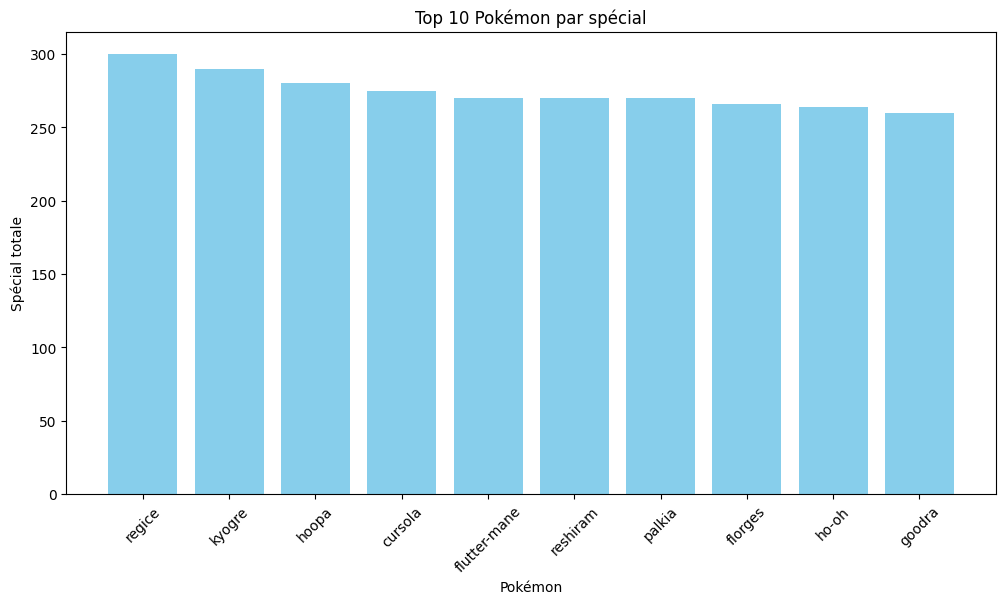

In [0]:
# Convertir Spark DataFrame en Pandas
top_pokemon_total_special_pd = top_pokemon_total_special_df.toPandas()

# Bar chart des top 10 Pokémon par spécial
plt.figure(figsize=(12, 6))
plt.bar(top_pokemon_total_special_pd['name'], top_pokemon_total_special_pd['total_special'], color='skyblue')
plt.title('Top 10 Pokémon par spécial')
plt.xlabel('Pokémon')
plt.ylabel('Spécial totale')
plt.xticks(rotation=45)
plt.show()

In [0]:
# Trier les Pokémon par points de vie décroissant et sélectionner les 10 premiers
top_pokemon_hp_df = df_clean.orderBy(df_clean.hp.desc()).limit(10)
display(top_pokemon_hp_df)

id,name,height,weight,hp,attack,defense,special-attack,special-defense,speed,types,total_power,total_attack,total_defense,total_physic,total_special
242,blissey,15,468,255,10,10,75,135,55,List(normal),540,85,145,20,210
113,chansey,11,346,250,5,5,35,105,50,List(normal),450,40,110,10,140
799,guzzlord,55,8880,223,101,53,97,53,43,"List(dark, dragon)",570,198,106,154,150
895,regidrago,21,2000,200,100,50,100,50,80,List(dragon),580,200,100,150,150
202,wobbuffet,13,285,190,33,58,33,58,33,List(psychic),405,66,116,91,91
321,wailord,145,3980,170,90,45,90,45,60,List(water),500,180,90,135,135
975,cetitan,45,7000,170,113,65,45,55,73,List(ice),521,158,120,178,100
594,alomomola,12,316,165,75,80,40,45,65,List(water),470,115,125,155,85
143,snorlax,21,4600,160,110,65,65,110,30,List(normal),540,175,175,175,175
1003,ting-lu,27,6997,155,110,125,55,80,45,"List(dark, ground)",570,165,205,235,135


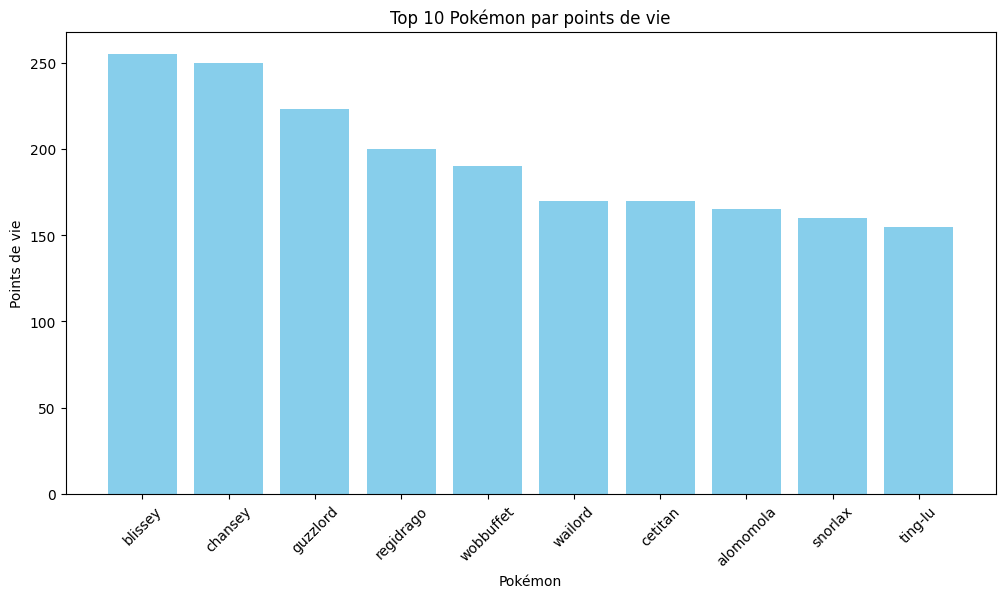

In [0]:
# Convertir Spark DataFrame en Pandas
top_pokemon_hp_pd = top_pokemon_hp_df.toPandas()

# Bar chart des top 10 Pokémon par points de vie
plt.figure(figsize=(12, 6))
plt.bar(top_pokemon_hp_pd['name'], top_pokemon_hp_pd['hp'], color='skyblue')
plt.title('Top 10 Pokémon par points de vie')
plt.xlabel('Pokémon')
plt.ylabel('Points de vie')
plt.xticks(rotation=45)
plt.show()

In [0]:
# Trier les Pokémon par vitesse décroissant et sélectionner les 10 premiers
top_pokemon_speed_df = df_clean.orderBy(df_clean.speed.desc()).limit(10)
display(top_pokemon_speed_df)

id,name,height,weight,hp,attack,defense,special-attack,special-defense,speed,types,total_power,total_attack,total_defense,total_physic,total_special
894,regieleki,12,1450,80,100,50,100,50,200,List(electric),580,200,100,150,150
291,ninjask,8,120,61,90,45,50,50,160,"List(bug, flying)",456,140,95,135,100
795,pheromosa,18,250,71,137,37,137,37,151,"List(bug, fighting)",570,274,74,174,174
386,deoxys-normal,17,608,50,150,50,150,50,150,List(psychic),600,300,100,200,200
101,electrode,12,666,60,50,70,80,80,150,List(electric),490,130,150,120,160
617,accelgor,8,253,80,70,40,100,60,145,List(bug),495,170,100,110,160
807,zeraora,15,445,88,112,75,102,80,143,List(electric),600,214,155,187,182
887,dragapult,30,500,88,120,75,100,75,142,"List(dragon, ghost)",600,220,150,195,175
888,zacian,28,1100,92,120,115,80,115,138,List(fairy),660,200,230,235,195
889,zamazenta,29,2100,92,120,115,80,115,138,List(fighting),660,200,230,235,195


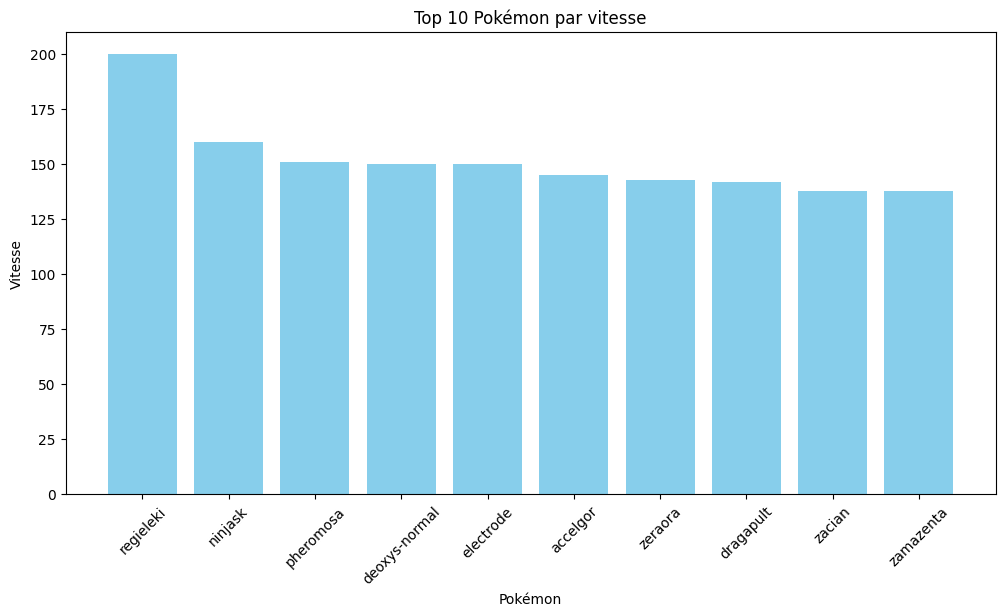

In [0]:
# Convertir Spark DataFrame en Pandas
top_pokemon_speed_pd = top_pokemon_speed_df.toPandas()

# Bar chart des top 10 Pokémon par vitesse
plt.figure(figsize=(12, 6))
plt.bar(top_pokemon_speed_pd['name'], top_pokemon_speed_pd['speed'], color='skyblue')
plt.title('Top 10 Pokémon par vitesse')
plt.xlabel('Pokémon')
plt.ylabel('Vitesse')
plt.xticks(rotation=45)
plt.show()

Création de cluster pour catégoriser les Pokemon en fonction de leurs statistiques

In [0]:
# Vérification du type de chaque variable
print(df_clean.describe())

DataFrame[summary: string, id: string, name: string, height: string, weight: string, hp: string, attack: string, defense: string, special-attack: string, special-defense: string, speed: string, total_power: string, total_attack: string, total_defense: string, total_physic: string, total_special: string]


In [0]:
# Liste des colonnes à convertir
columns_to_convert = ['hp', 'attack', 'defense', 'special-attack', 'special-defense', 'speed', 'total_attack', 'total_defense', 'total_physic', 'total_special']

# Conversion des colonnes en numérique
for col_name in columns_to_convert:
    df_clean = df_clean.withColumn(col_name, col(col_name).cast(DoubleType()))

# Vérifie les types de données après conversion
df_clean.printSchema()

root
 |-- id: long (nullable = true)
 |-- name: string (nullable = true)
 |-- height: long (nullable = true)
 |-- weight: long (nullable = true)
 |-- hp: double (nullable = true)
 |-- attack: double (nullable = true)
 |-- defense: double (nullable = true)
 |-- special-attack: double (nullable = true)
 |-- special-defense: double (nullable = true)
 |-- speed: double (nullable = true)
 |-- types: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- total_power: long (nullable = true)
 |-- total_attack: double (nullable = true)
 |-- total_defense: double (nullable = true)
 |-- total_physic: double (nullable = true)
 |-- total_special: double (nullable = true)



/databricks/python/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f5039a29440>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self

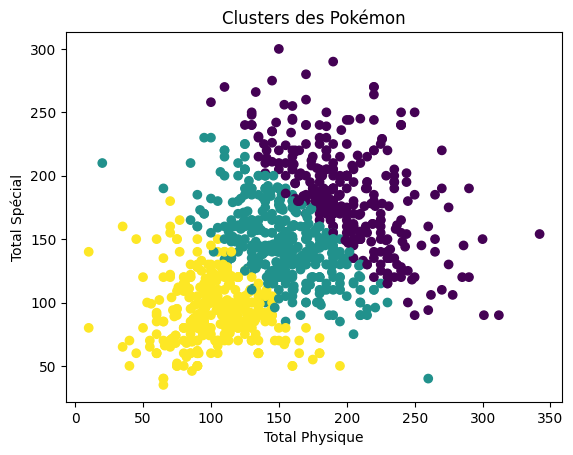

In [0]:
# Convertir le DataFrame PySpark en DataFrame pandas
df_clean_pandas = df_clean.toPandas()

# Sélectionner les variables pertinentes pour le clustering
features = df_clean_pandas[['hp', 'attack', 'defense', 'special-attack', 'special-defense', 'speed', 'total_attack', 'total_defense', 'total_physic', 'total_special']]

# Appliquer l'algorithme des KMeans avec 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
df_clean_pandas['cluster'] = kmeans.fit_predict(features)

# Visualiser les clusters sur un graphique 2D (attaque vs défense par exemple)
plt.scatter(df_clean_pandas['total_physic'], df_clean_pandas['total_special'], c=df_clean_pandas['cluster'])
plt.xlabel('Total Physique')
plt.ylabel('Total Spécial')
plt.title('Clusters des Pokémon')
plt.show()